<a href="https://colab.research.google.com/github/l-kaif-l/EEG_classification/blob/main/EFFB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EfficientNetB2 model using spectrogram features. Mention that spectrograms are visual representations of EEG data, and this model is trained to classify brain activities.

Highlight that this notebook achieves a cross-validation (CV) score of 0.64

In [ ]:
import os
import sys
import gc
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import pytorch_lightning as pl
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import KFold, GroupKFold

# Data Loading

In [ ]:
VER = 5
LOAD_MODELS_FROM = '/kaggle/input/hms-efficientnetb0-pt-ckpts/'

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

In [ ]:
# Mixed precision training is enabled to speed up training and reduce memory usage by using both 16-bit and 32-bit floating-point types.
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [ ]:
train = df.groupby('eeg_id')[
    ['spectrogram_id', 'spectrogram_label_offset_seconds']
].agg({'spectrogram_id': 'first', 'spectrogram_label_offset_seconds': 'min'})
train.columns = ['spec_id', 'min']

tmp = df.groupby('eeg_id')[
    ['spectrogram_id','spectrogram_label_offset_seconds']
].agg({'spectrogram_label_offset_seconds' :'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1, keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [ ]:
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:
    spectrograms = {}
    for i,f in enumerate(files):
        if i % 100 == 0:
            print(i, ', ', end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets


In [ ]:
READ_EEG_SPEC_FILES = False

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i % 100 == 0:
            print(i, ', ', end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

In [ ]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}


class EEGDataset(Dataset):

    def __init__(self, data, augment=False, mode='train', specs=spectrograms, eeg_specs=all_eegs):
        self.data = data
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.__getitems__([index])

    def __getitems__(self, indices):
        X, y = self._generate_data(indices)
        if self.augment:
            X = self._augment(X)
        if self.mode == 'train':
            return list(zip(X, y))
        else:
            return X

    def _generate_data(self, indexes):
        X = np.zeros((len(indexes), 128, 256, 8),dtype='float32')
        y = np.zeros((len(indexes), 6),dtype='float32')
        img = np.ones((128, 256),dtype='float32')

        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode == 'test':
                r = 0
            else:
                r = int((row['min'] + row['max'])//4)

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T

                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)

                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)

                # CROP TO 256 TIME STEPS
                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0

            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j, :, :, 4:] = img

            if self.mode != 'test':
                y[j,] = row[TARGETS]

        return X, y

    def _random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            # albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']

    def __augment(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i,] = self._random_transform(img_batch[i,])
        return img_batch

In [ ]:
dataset = EEGDataset(train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

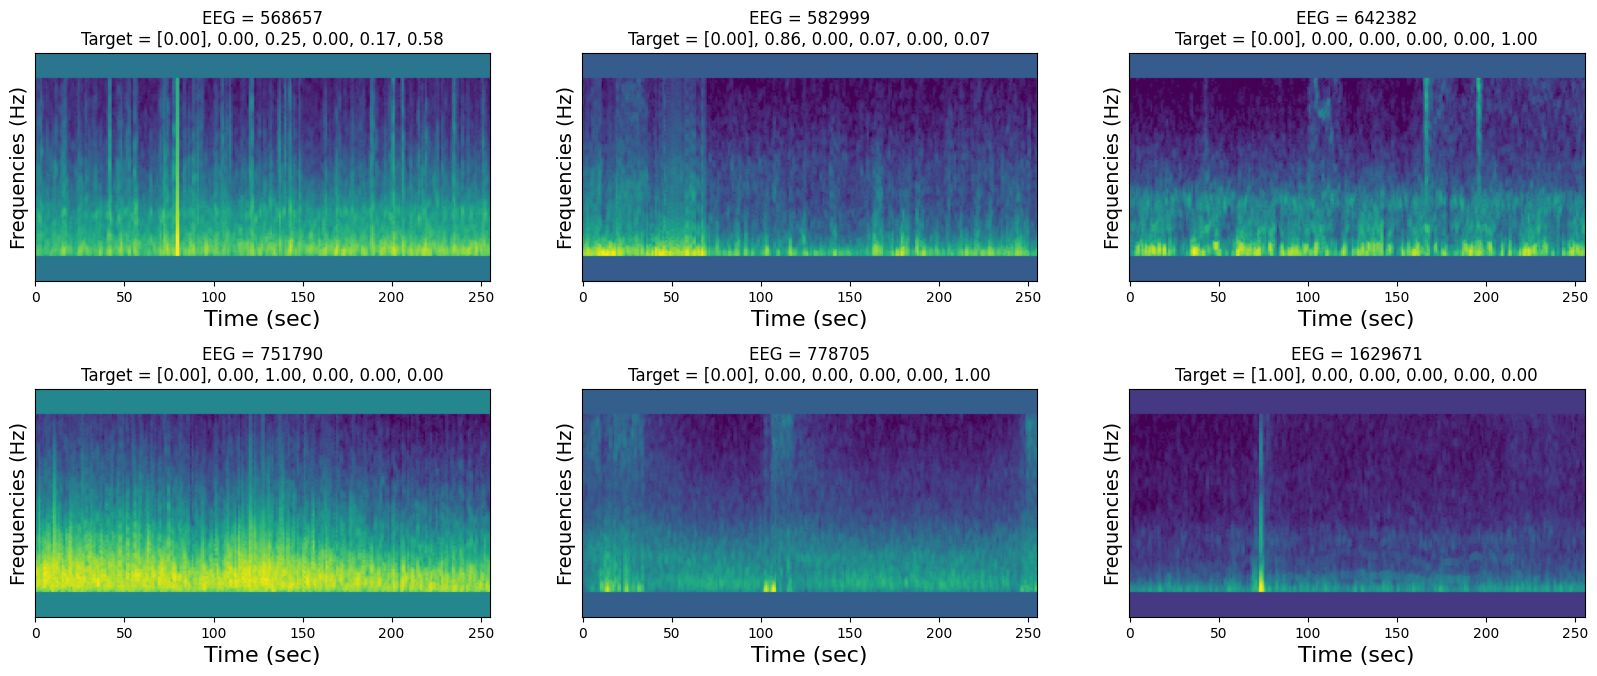

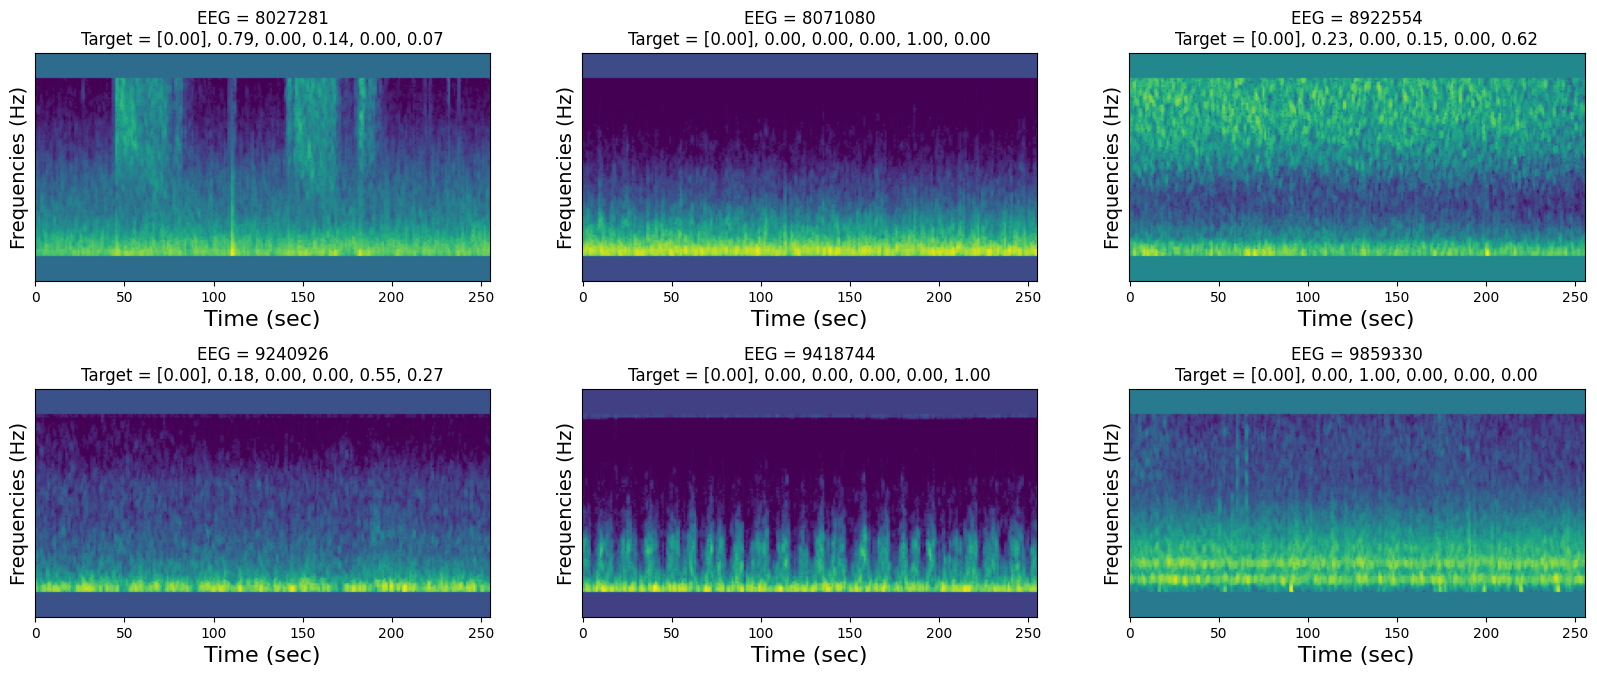

In [ ]:
ROWS = 2
COLS = 3
BATCHES = 2

for i, (x, y) in enumerate(dataloader):
    plt.figure(figsize=(20, 8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS + k + 1)
            t = y[j*COLS + k]
            img = torch.flip(x[j*COLS+k, :, :, 0], (0,))
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}]'
            for s in t[1:]:
                tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i == BATCHES-1:
        break

In [ ]:
del dataset, dataloader
gc.collect()

15614

# Training

In [ ]:
WEIGHTS_FILE = '/kaggle/input/hms-efficientnetb0-pt-ckpts/efficientnet_b0_rwightman-7f5810bc.pth'


class EEGEffnetB0(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.base_model = efficientnet_b0()
        self.base_model.load_state_dict(torch.load(WEIGHTS_FILE))
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, 6, dtype=torch.float32)
        self.prob_out = nn.Softmax()

    def forward(self, x):
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)
        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=1)

        if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
            x = torch.concat([x1, x2], dim=2)
        elif USE_EEG_SPECTROGRAMS:
            x = x2
        else:
            x = x1
        x = torch.concat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)

        out = self.base_model(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        out = F.log_softmax(out, dim=1)
        kl_loss = nn.KLDivLoss(reduction='batchmean')
        loss = kl_loss(out, y)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return F.softmax(self(batch), dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
all_oof = []
all_true = []
valid_loaders = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
    print('#'*25)
    print(f'### Fold {i+1}')

    train_ds = EEGDataset(train.iloc[train_index])
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=32, num_workers=3)
    valid_ds = EEGDataset(train.iloc[valid_index], mode='valid')
    valid_loader = DataLoader(valid_ds, shuffle=False, batch_size=64, num_workers=3)

    print(f'### Train size: {len(train_index)}, Valid size: {len(valid_index)}')
    print('#'*25)

    trainer = pl.Trainer(max_epochs=4)
    model = EEGEffnetB0()
    if LOAD_MODELS_FROM is None:
        trainer.fit(model=model, train_dataloaders=train_loader)
        trainer.save_checkpoint(f'EffNet_v{VER}_f{i}.ckpt')

    valid_loaders.append(valid_loader)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    del trainer, model
    gc.collect()

#########################
### Fold 1
### Train size: 13671, Valid size: 3418
#########################
#########################
### Fold 2
### Train size: 13671, Valid size: 3418
#########################
#########################
### Fold 3
### Train size: 13671, Valid size: 3418
#########################
#########################
### Fold 4
### Train size: 13671, Valid size: 3418
#########################
#########################
### Fold 5
### Train size: 13672, Valid size: 3417
#########################


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for i in range(5):
    print('#'*25)
    print(f'### Validating Fold {i+1}')

    ckpt_file = f'EffNet_v{VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/EffNet_v{VER}_f{i}.ckpt'
    model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    with torch.inference_mode():
        for val_batch in valid_loaders[i]:
            val_batch = val_batch.to(device)
            oof = torch.softmax(model(val_batch), dim=1).cpu().numpy()
            all_oof.append(oof)
    del model
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Validating Fold 1
#########################
### Validating Fold 2
#########################
### Validating Fold 3
#########################
### Validating Fold 4
#########################
### Validating Fold 5


In [ ]:
oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)


CV Score KL-Div for EfficientNetB2 = 0.8531805911043548
